In [4]:
import sys
sys.path.insert(0, '../')
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from src.config import PARAM, PATH_SHAPES, PATH_RESOURCES, PATH_RESULTS
from src.geo_data import load_geonames
from src.geoplot import geoplot_points, annotate_geoplot

In [5]:
loc = 'nl'
basemap = geopandas.read_file(PATH_SHAPES / loc)

In [6]:
df_geo = pd.read_pickle(PATH_RESOURCES / 'geonames/df_geonames.pkl').query("country_code == 'NL'")

In [7]:
geometry = [Point(xy) for xy in zip(df_geo.longitude, df_geo.latitude)]
crs = {'init' :'epsg:4326'}
gdf_ = geopandas.GeoDataFrame(df_geo, crs=crs, geometry=geometry)
gdf_ = gdf_.to_crs(basemap.crs)

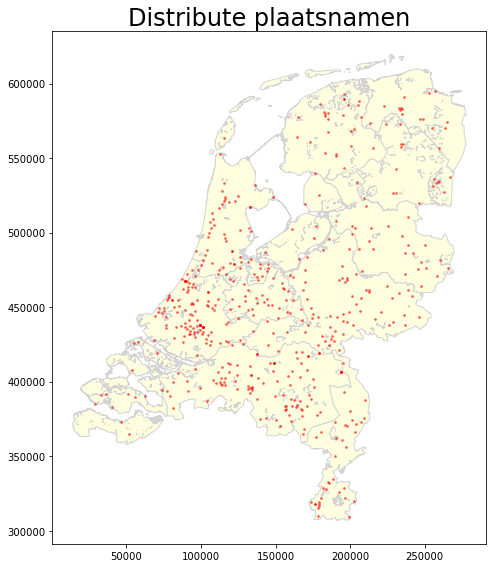

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
geoplot_points(ax, basemap, gdf_, 3, title='Distribute plaatsnamen')
plt.savefig(PATH_RESULTS / f"distribution_places_{loc}.png")
plt.tight_layout()

In [9]:
df_attr_counts = pd.read_pickle('../results/df_attribute_counts.pkl')
df = df_attr_counts.xs('places_nl', level=0)
df = df.append(df_attr_counts.xs('places_fr', level=0))
df = df.rename(columns={'index': 'naam'})

df_annotations = pd.read_pickle(PATH_RESULTS / 'df_annotations_places_nl.pkl')
df_annotations = df_annotations.append(pd.read_pickle(PATH_RESULTS / 'df_annotations_places_fr.pkl'))
df_annotations['positive'] = df_annotations.annotation == '+'
positives = df_annotations.groupby('phrase')['positive'].any()

df_ = df[df.index.isin(positives[positives].index)]

In [10]:
gdf = gdf_.merge(df_, how='left', left_on='alternate_name', right_index=True)

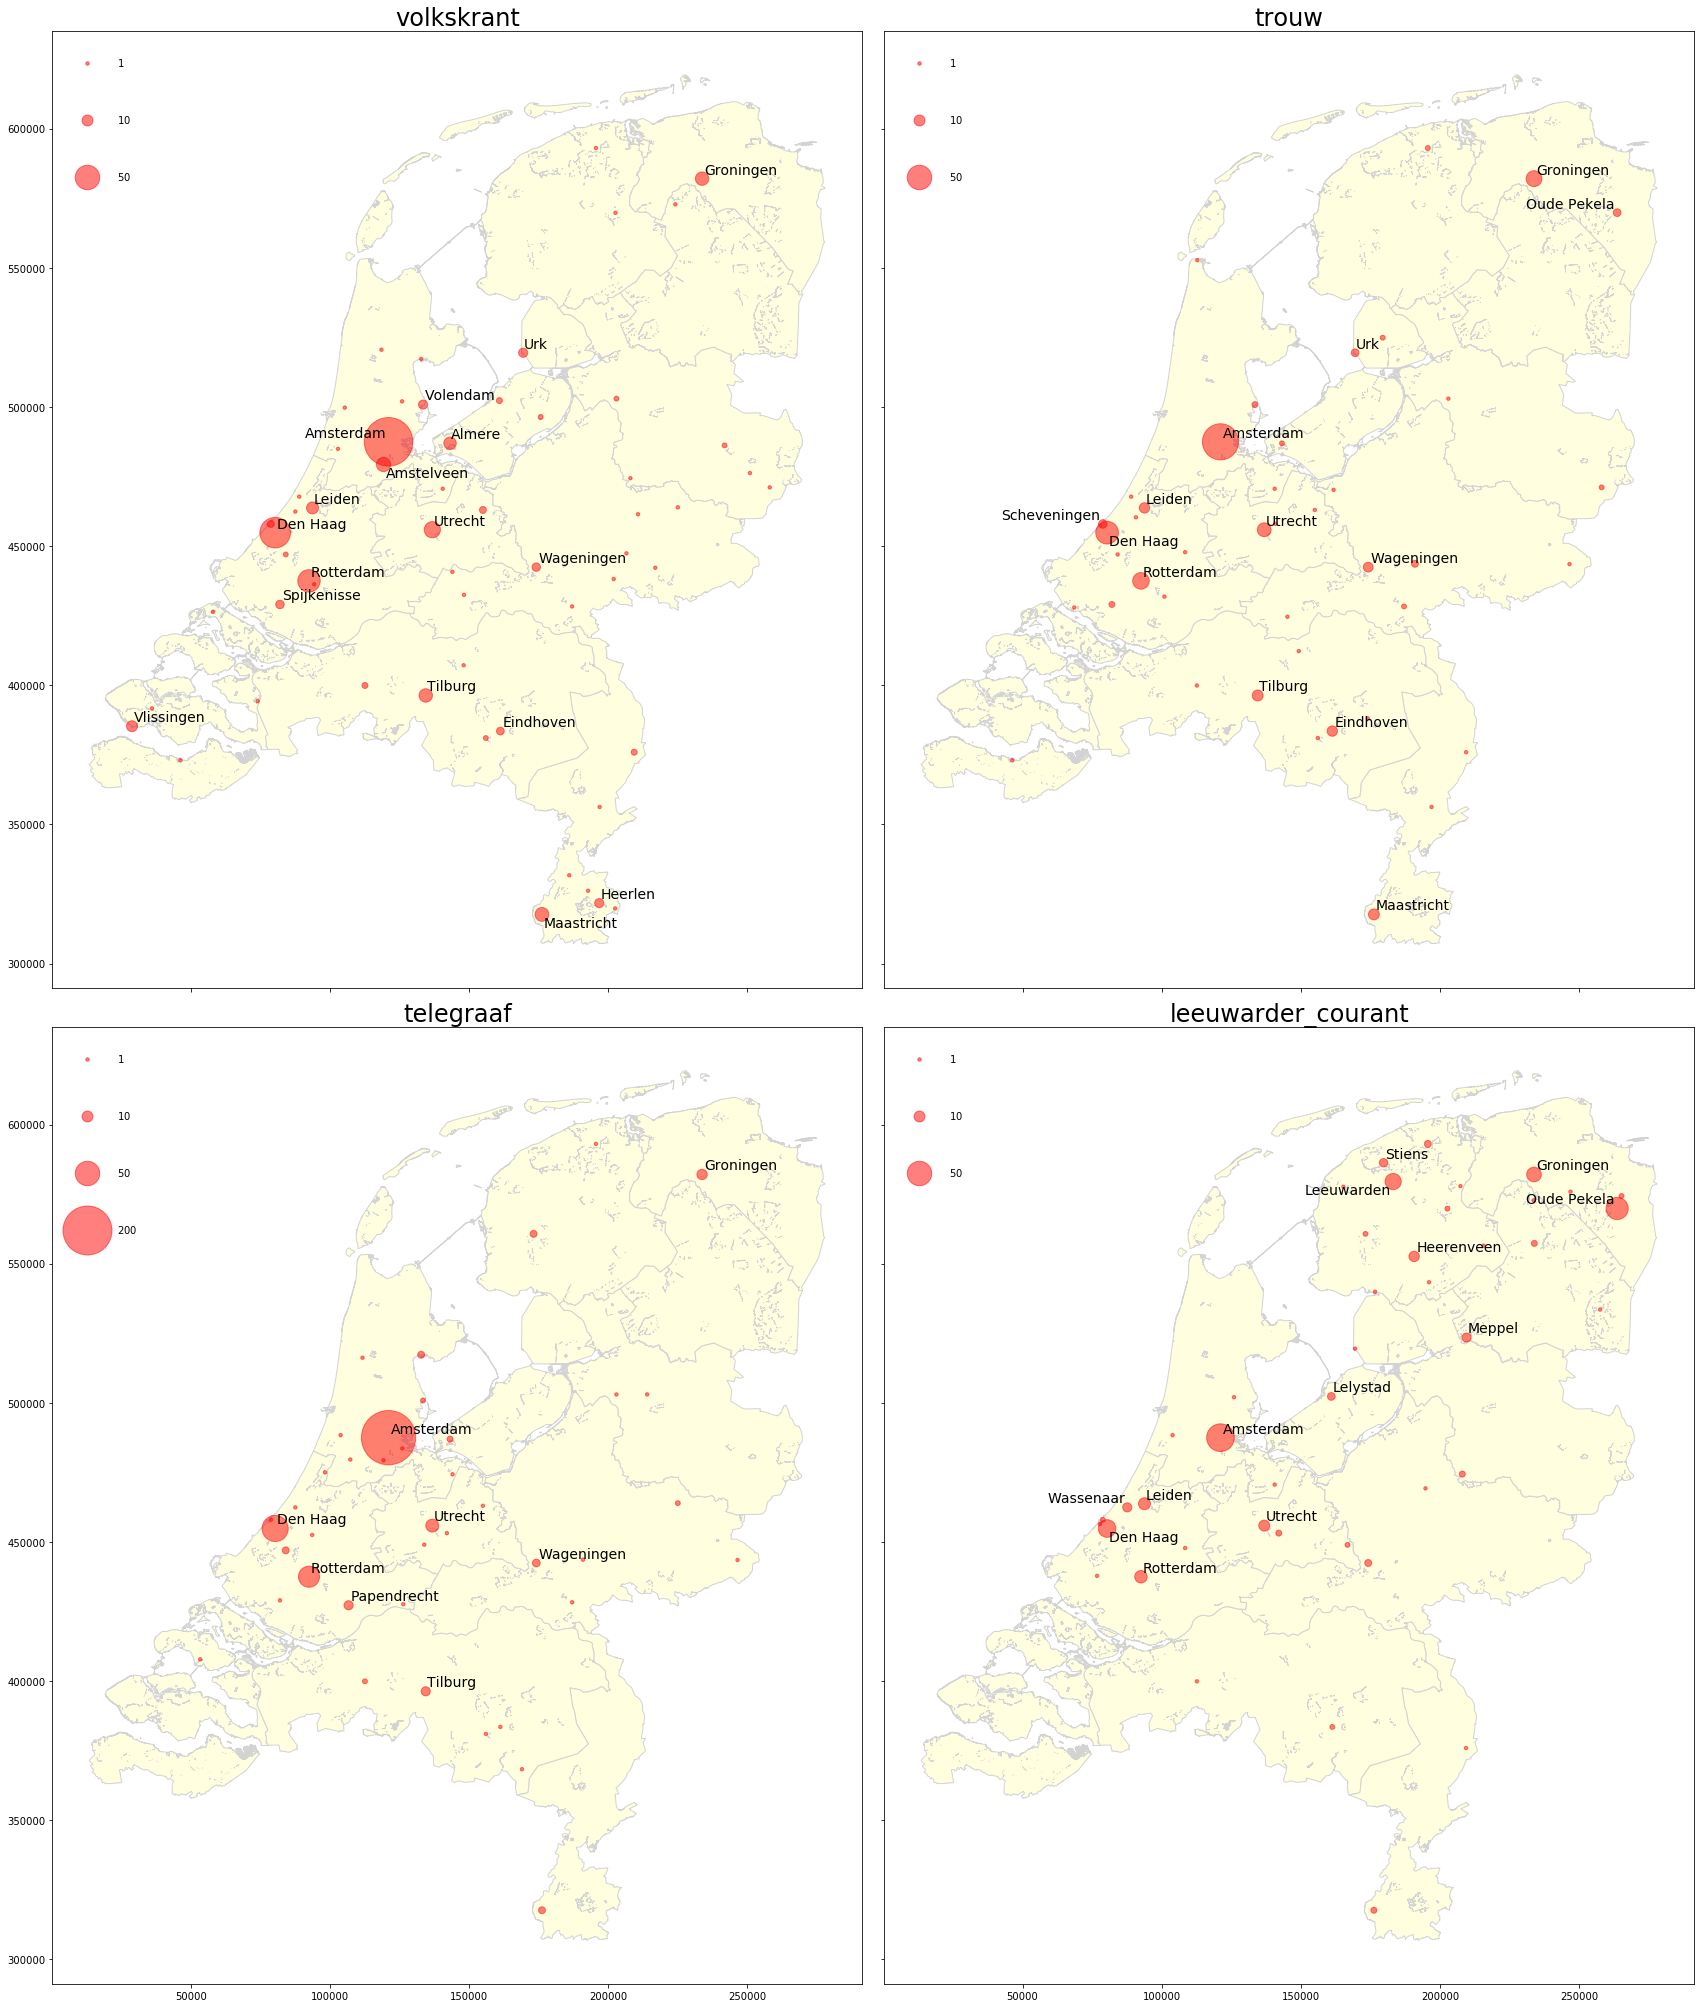

In [11]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(24, 28))
for ax, batch in zip(axs.reshape(-1), PARAM.lexisnexis.batches):
    ax = geoplot_points(ax, basemap, gdf, gdf[batch].fillna(0), title=batch, factor=12)
    places = gdf.dropna(subset=[batch]).loc[gdf[batch] >= 5]
    annotate_geoplot(ax, places, 'alternate_name')
plt.savefig(PATH_RESULTS / f"places_{loc}.png")
plt.tight_layout()